In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from torchvision.transforms import ToTensor
from lightning_module import LitPromptIR

def show_grid(ckpt, root='data/test/degraded', n=9, device='cuda'):
    model = LitPromptIR.load_from_checkpoint(ckpt, map_location=device)
    model.eval().to(device)
    t = ToTensor()

    sel = np.random.choice(list(Path(root).glob('*.png')), n, False)
    s = int(np.sqrt(n))
    fig, ax = plt.subplots(s, s, figsize=(8,8))
    with torch.no_grad():
        for a, p in zip(ax.flatten(), sel):
            x = t(Image.open(p).convert('RGB')).unsqueeze(0).to(device)
            y = model(x).clamp(0,1).cpu().squeeze()
            a.imshow(y.permute(1,2,0).numpy())
            a.set_title(p.name, fontsize=8)
            a.axis('off')
    plt.tight_layout()


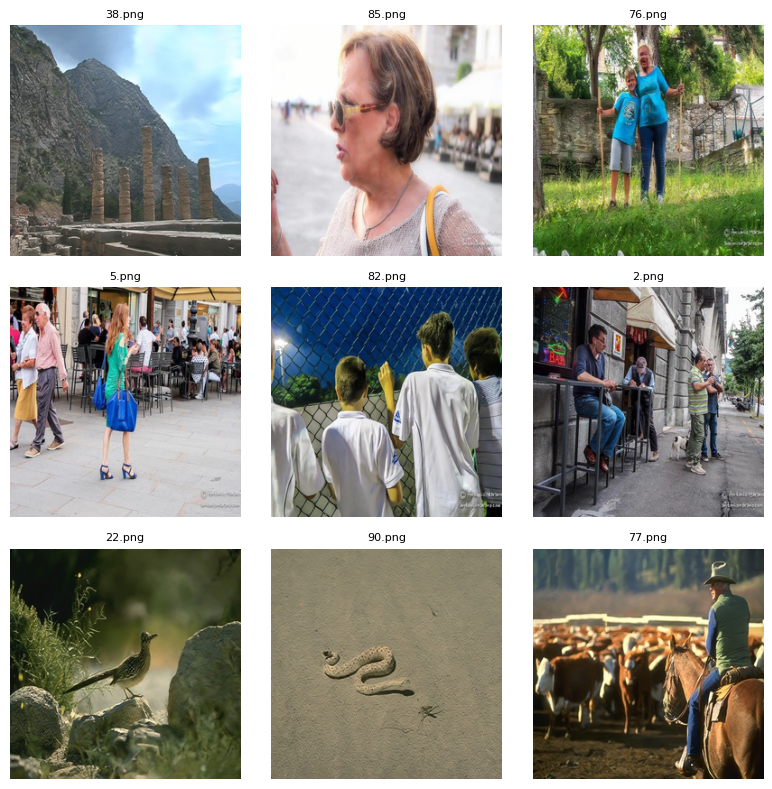

In [6]:
show_grid("ckpts/promptirnewssim-epoch=187-val_PSNR=0.00.ckpt")

In [30]:
from datasets_hw4 import get_train_val_loaders

def tensor2np(img):
    """(C,H,W) ∈[0,1]  →  (H,W,C) uint8"""
    return (img.detach().cpu().permute(1, 2, 0).clamp(0, 1).numpy() * 255).astype("uint8")

def visualize_val_selected(
    ckpt="ckpts/promptirnewssim-epoch=187-val_PSNR=0.00.ckpt",
    data_root="data",
    patch: int = 256,
    device: str = "cuda",
):
    # 只拿 val loader；不要 shuffle，保持固定順序
    _, val_loader = get_train_val_loaders(
        root=data_root, batch=1, num_workers=0, patch=patch
    )

    # 準備要抓取的索引：0,1,-2,-1
    total_val = len(val_loader.dataset)
    target_ids = {0, 1, total_val - 2, total_val - 1}

    model = LitPromptIR.load_from_checkpoint(ckpt, map_location=device)
    model.eval().to(device)

    fig, axes = plt.subplots(4, 3, figsize=(9, 12))  # 4 列 × 3 欄

    with torch.no_grad():
        row = 0
        for idx, batch in enumerate(val_loader):
            if idx not in target_ids:
                continue

            x = batch["degraded"].to(device)
            y_pred = model(x).clamp(0, 1)
            y_gt = batch["clean"]

            axes[row, 0].imshow(tensor2np(x[0]))
            axes[row, 0].set_title("Input")
            axes[row, 1].imshow(tensor2np(y_pred[0]))
            axes[row, 1].set_title("Model Output")
            axes[row, 2].imshow(tensor2np(y_gt[0]))
            axes[row, 2].set_title("Ground Truth")

            for c in range(3):
                axes[row, c].axis("off")

            row += 1
            if row == 4:
                break  # 已經收集到 4 張

    plt.tight_layout()
    plt.show()

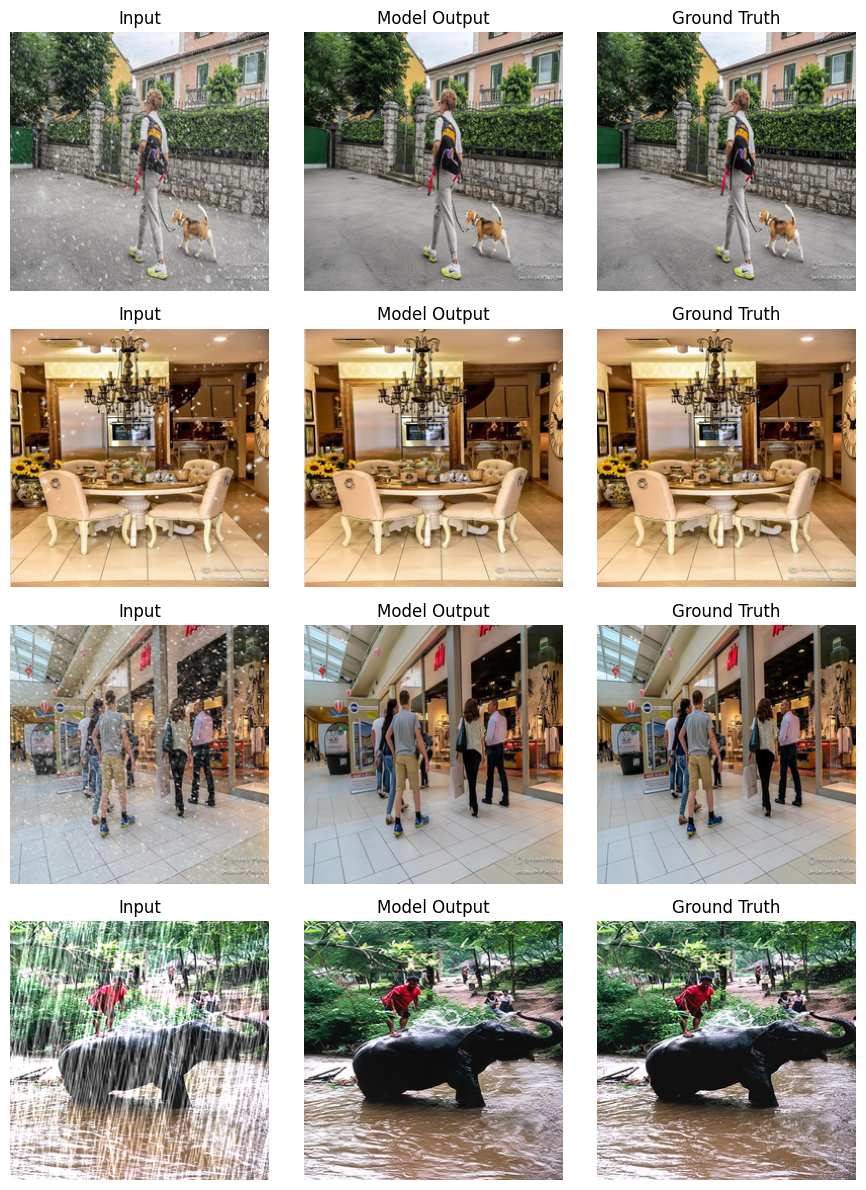

In [32]:
visualize_val_selected("ckpts/promptirnewssim-epoch=187-val_PSNR=0.00.ckpt")

In [33]:
def compare_models_val_selected(
    ckpt_a: str,
    ckpt_b: str,
    data_root: str = "data",
    patch: int = 256,
    device: str = "cuda",
):
    """顯示 val set 的第 0、1、倒數 2、倒數 1 張，共 4 張
       欄位：Input｜Model-A Output｜Model-B Output
    """
    # ----- dataloader（固定順序、batch=1） -----
    _, val_loader = get_train_val_loaders(
        root=data_root, batch=1, num_workers=0, patch=patch
    )
    total_val = len(val_loader.dataset)
    target_ids = {0, 1, total_val - 2, total_val - 1}

    # ----- 兩個模型 -----
    model_a = LitPromptIR.load_from_checkpoint(ckpt_a, map_location=device)
    model_b = LitPromptIR.load_from_checkpoint(ckpt_b, map_location=device)
    model_a.eval().to(device)
    model_b.eval().to(device)

    fig, axes = plt.subplots(4, 3, figsize=(9, 12))  # 4 列 × 3 欄

    with torch.no_grad():
        row = 0
        for idx, batch in enumerate(val_loader):
            if idx not in target_ids:
                continue

            x = batch["degraded"].to(device)
            y_a = model_a(x).clamp(0, 1)
            y_b = model_b(x).clamp(0, 1)

            axes[row, 0].imshow(tensor2np(x[0]))
            axes[row, 0].set_title("Input")

            axes[row, 1].imshow(tensor2np(y_a[0]))
            axes[row, 1].set_title("Model A")

            axes[row, 2].imshow(tensor2np(y_b[0]))
            axes[row, 2].set_title("Model B")

            for c in range(3):
                axes[row, c].axis("off")

            row += 1
            if row == 4:
                break

    plt.tight_layout()
    plt.show()

In [ ]:
compare_models_val_selected(
    ckpt_a="ckpts/promptirnewssim-epoch=187-val_PSNR=0.00.ckpt",
    ckpt_b="ckpts/promptir_v2-epoch=098-val_PSNR=31.05.ckpt",
    device="cuda",
)